# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [182]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

from sklearn import metrics
from scipy.stats import ks_2samp

In [214]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [62]:
def gera_bivariada(df: pd.DataFrame, var_resposta: str, var_explicativa: str) -> pd.DataFrame:
    
    # Estrutura inicial da tabela cruzada
    tab_cruzada = pd.crosstab(index = df[var_explicativa], 
                          columns = df[var_resposta], 
                          margins = True).rename({'All': 'total'}).rename({'All': 'total'}, axis=1)


    # Cálculo da probabilidade
    tab_cruzada['probabilidade'] = tab_cruzada.iloc[:,1] / tab_cruzada['total']


    # Cálculo da chance
    tab_cruzada['chance'] = tab_cruzada['probabilidade'] / (1 - tab_cruzada['probabilidade'])


    # Razão de chances (odds ratio): razão entre as chances
    tab_cruzada['razao_chances'] = tab_cruzada['chance'] / tab_cruzada.loc['total', 'chance']


    # Logito: log(odds)
    tab_cruzada['logito'] = np.log(tab_cruzada['chance'])


    # WOE: log(odds ratio)
    tab_cruzada['woe'] = np.log(tab_cruzada['razao_chances'])

    
    return tab_cruzada

In [63]:
gera_bivariada(df, 'flag_doente', 'sex')

flag_doente,0,1,total,probabilidade,chance,razao_chances,logito,woe
sex,,,,,,,,
0.0,72,25,97,0.257732,0.347222,0.409672,-1.057790,-0.892398
1.0,92,114,206,0.553398,1.239130,1.461996,0.214410,0.379802
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [90]:
def gera_bivariada_quantitativa(df: pd.DataFrame, var_resposta: str, var_explicativa: str, qtd_quebras: int=5) -> pd.DataFrame:
    
    df['intervals'] = pd.qcut(df['age'], q = qtd_quebras)

    tab_cruzada = pd.crosstab(df['intervals'], 
                              df['flag_doente'], 
                              margins = True).rename({'All': 'total'}).rename({'All': 'total'}, axis=1)

    # Cálculo da probabilidade
    tab_cruzada['probabilidade'] = tab_cruzada.iloc[:,1] / tab_cruzada['total']

    # Cálculo da chance
    tab_cruzada['chance'] = tab_cruzada['probabilidade'] / (1 - tab_cruzada['probabilidade'])

    # Razão de chances (odds ratio): razão entre as chances
    tab_cruzada['razao_chances'] = tab_cruzada['chance'] / tab_cruzada.loc['total', 'chance']

    # Logito: log(odds)
    tab_cruzada['logito'] = np.log(tab_cruzada['chance'])


    # WOE: log(odds ratio)
    tab_cruzada['woe'] = np.log(tab_cruzada['razao_chances'])

    
    return tab_cruzada

In [91]:
gera_bivariada_quantitativa(df, 'flag_doente', 'age', 5)

flag_doente,0,1,total,probabilidade,chance,razao_chances,logito,woe
intervals,,,,,,,,
"(28.999, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392
total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

**Ao observar o resultado do treinamento do modelo através da função summary(), pode-se notar:**

* Duas categorias da variável CP não são significativas (categorias 2 e 3)
* Todo o restante das variáveis são significativas, em especial CP = 4

In [234]:
reg_log = smf.logit(data = df, 
                    formula = 'flag_doente ~ C(sex) + C(cp) + trestbps + age').fit()

reg_log.summary()

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Tue, 30 May 2023   Pseudo R-squ.:                  0.3097
Time:                        21:26:58   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -8.3407      1.621     -5.145      0.000     -11.518      -5.163
C(sex)[T.1.0]     1.8094      0.353      5.130      0.000       1.118       2.501
C(cp)[T.2.0]     -0.0617      0.636     -0.097      0.923      -1.309       1.186
C(cp)[T.3.0]      0.0715      0.573      0.125      0.901      -1.051       1.194
C(cp)[T.4.0]      2.4789      0.553      4.485      0.000       1.396       3.562
trestbps          0.0193      0.009      2.261      0.024       0.003       0.036
age               0.0567      0.018      3.120      0.002       0.021       0.092
=================================================================================
"""

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [235]:
# Cálculo das previsões
df['previsoes'] = reg_log.predict(df)

# Categorização das previsoes
cat_previsoes = pd.qcut(df['previsoes'], q=5)

agrupamento = df.groupby(cat_previsoes)

# Quantidade por grupo
calibragem = agrupamento[['previsoes']].count().rename({'previsoes': 'quantidade'}, axis=1)

# Probabilidade média por grupo das previsoes
calibragem['previsao_media'] = agrupamento[['previsoes']].mean()

# Probabilidade média por grupo dos valores reais
calibragem['porcentagem_media_real'] = agrupamento[['flag_doente']].mean()

calibragem

,quantidade,previsao_media,porcentagem_media_real
previsoes,,,
"(0.0131, 0.143]",62,0.072008,0.080645
"(0.143, 0.287]",59,0.209626,0.152542
"(0.287, 0.586]",62,0.435175,0.483871
"(0.586, 0.822]",59,0.708861,0.762712
"(0.822, 0.944]",61,0.874819,0.819672


Text(0.5, 0, 'Grupo')

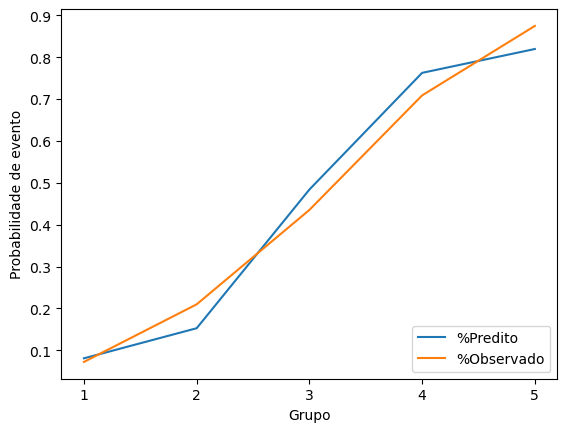

In [170]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = calibragem['porcentagem_media_real'].plot(label='%Predito')
ax = calibragem['previsao_media'].plot(label='%Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [236]:
# Acurácia
acuraria = metrics.accuracy_score(df['flag_doente'], df['previsoes'] > 0.5)

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['previsoes'])
auc_ = metrics.auc(fpr, tpr)

#Gini
gini = 2*auc_ -1

#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'previsoes'], df.loc[df['flag_doente'] != 1, 'previsoes']).statistic




print(f'Acurácia = {acuraria}')
print(f'Gini     = {gini}')
print(f'KS       = {ks}')

Acurácia = 0.7953795379537953
Gini     = 0.7038954202491665
KS       = 0.5929549043691876


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

**Removendo a variavel CP**

Adicionando 'ca' e 'exang', foi possível melhorar os indicadores do modelo em 1%

In [249]:
reg_log = smf.logit(data = df, 
                    formula = 'flag_doente ~ C(sex) + C(cp) + trestbps + age + C(ca) + C(exang)').fit()

reg_log.summary()

Optimization terminated successfully.
         Current function value: 0.388478
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      291
Method:                           MLE   Df Model:                           11
Date:                Tue, 30 May 2023   Pseudo R-squ.:                  0.4368
Time:                        21:29:39   Log-Likelihood:                -117.71
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 3.028e-33
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -7.5717      1.817     -4.168      0.000     -11.132      -4.011
C(sex)[T.1.0]       1.7031      0.400      4.262      0.000       0.920       2.486
C(cp)[T.2.0]        0.1098      0.704      0.156      0.876      -1.270       1.490
C(cp)[T.3.0]       -0.0223      0.641     -0.035      0.972      -1.278       1.233
C(cp)[T.4.0]        2.0096      0.613      3.277      0.001       0.808       3.212
C(ca)[T.1.0]        1.9169      0.438      4.375      0.000       1.058       2.776
C(ca)[T.2.0]        2.4405      0.585      4.169      0.000       1.293       3.588
C(ca)[T.3.0]        2.6377      0.747      3.532      0.000       1.174       4.102
C(ca)[T.?]         -0.3048      1.506     -0.202      0.840      -3.256       2.646
C(exang)[T.1.0]     1.3453      0.378      3.556      0.000       0.604       2.087
trestbps            0.0247      0.010      2.448      0.014       0.005       0.044
age                 0.0118      0.021      0.566      0.571      -0.029       0.053
===================================================================================
"""

In [250]:
df['previsoes'] = reg_log.predict(df)


# Acurácia
acuraria = metrics.accuracy_score(df['flag_doente'], df['previsoes'] > 0.5)

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['previsoes'])
auc_ = metrics.auc(fpr, tpr)

#Gini
gini = 2*auc_ -1

#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'previsoes'], df.loc[df['flag_doente'] != 1, 'previsoes']).statistic




print(f'Acurácia = {acuraria}')
print(f'Gini     = {gini}')
print(f'KS       = {ks}')

# Valores anteriores:
#Acurácia = 0.7953795379537953
#Gini     = 0.7038954202491665
#KS       = 0.5929549043691876

Acurácia = 0.8085808580858086
Gini     = 0.8057115283383052
KS       = 0.6372170556237936
